# <b> Capstone Project </b>
-<b><i>Dipro Mondal</i></b>

## Importing Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# Seaborn plotting module
import seaborn as sns
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

## <b> Background problem and Data Acquisition</b>
<b>Q: Which is the best city to start a new Restaurant?</b>
 <i> India is already an overpopulated city. There are always a need for building new restaurants. In this capstone project I will try to recommend a city for bulding a restaurant based on restaurant population with respect to city population. For this I will require:</i>
<ul>
  <li>Population of India with respect to its different cities - to be obtained by scraping data from websites</li>
  <li>City latitude and longitude (location) - to be obtained by scraping data from websites</li>
  <li>Number of Restaurants for different cities - to be obtained from Foursquare</li>
</ul>
<i> I have selected the site <a> 'http://worldpopulationreview.com/countries/india-population/cities/ </a> which provides up-to-date data on population as well as the location coordinates required for my project. </i>

<b>Below I have scraped and cleaned the data and assigned a dataframe df for the data I will be using</b>

In [2]:
from bs4 import BeautifulSoup
import requests
source= requests.get('http://worldpopulationreview.com/countries/india-population/cities/').text
soup=BeautifulSoup(source,'lxml')
table=soup.findAll('table')[1]
df=pd.read_html(str(table))[0]
Location_link=table.findAll('a',href=True)
Lat=[];
Lon=[];
for i in range((len(Location_link))):
    k=Location_link[i].get('href')
    Lat.append(float(((k.split('?')[1]).split('=')[1]).split(',')[0]))
    Lon.append(float(((k.split('?')[1]).split('=')[1]).split(',')[1]))

df['Latitude']=Lat[0:]
df['Longitude']=Lon[0:]
df.rename(columns={'Name':'City', '2019 Population':'Population_2019'},inplace=True)
df.drop(['Location'], inplace=True, axis=1)  # Dropping previous index column
df.head()

,City,Population_2019,Latitude,Longitude
0,Mumbai,12691836,19.07283,72.88261
1,Delhi,10927986,28.65195,77.23149
2,Bengaluru,5104047,12.97194,77.59369
3,Kolkata,4631392,22.56263,88.36304
4,Chennai,4328063,13.08784,80.27847


<b>Next I will be using FourSquare Data.</b> <i>I need information on restaurants located at different cities from Foursquare so that I can recommend the best city where a new restaurant can be built. Then by sorting the ratio of city population with respect to the number of restaurants in the city I can recommend the city for building a new Restaurant. </i>

In [3]:
CLIENT_ID = 'GXLKBXNRITODYOPI3RQ4WECNXD3TR0FFBZLECJRJLCXJROPA' # your Foursquare ID


CLIENT_SECRET = '2VSQJHCG0MK0EKHID1DSXXMWYITGVCE1L1D2WSZBDKFFIYYA'

VERSION = '20180605' # Foursquare API version
LIMIT='400'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GXLKBXNRITODYOPI3RQ4WECNXD3TR0FFBZLECJRJLCXJROPA
CLIENT_SECRET:2VSQJHCG0MK0EKHID1DSXXMWYITGVCE1L1D2WSZBDKFFIYYA


In [4]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [5]:
India_venues = getNearbyVenues(names=df['City'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  );

Mumbai
Delhi
Bengaluru
Kolkata
Chennai
Ahmedabad
Hyderabad
Pune
Surat
Kanpur
Jaipur
Navi Mumbai
Lucknow
Nagpur
Indore
Patna
Bhopal
Ludhiana
Tirunelveli
Agra
Vadodara
Gorakhpur
Nashik
Pimpri
Kalyan
Thane
Meerut
Nowrangapur
Faridabad
Ghaziabad
Dombivli
Rajkot
Varanasi
Amritsar
Allahabad
Visakhapatnam
Teni
Jabalpur
Haora
Aurangabad
Shivaji Nagar
Solapur
Srinagar
Chandigarh
Coimbatore
Jodhpur
Madurai
Guwahati
Gwalior
Vijayawada
Mysore
Ranchi
Hubli
Jalandhar
Thiruvananthapuram
Salem
Tiruchirappalli
Kota
Bhubaneshwar
Aligarh
Bareilly
Moradabad
Bhiwandi
Raipur
Gorakhpur
Bhilai
Jamshedpur
Borivli
Cochin
Amravati
Sangli
Cuttack
Bikaner
Warangal
Bhavnagar
Nanded
Raurkela
Guntur
Dehra Dun
Bhayandar
Durgapur
Ajmer
Ulhasnagar
Kolhapur
Shiliguri
Bilimora
Karol Bagh
Asansol
Jamnagar
Saharanpur
Gulbarga
Bhatpara
Jammu
Kurnool
Ujjain
Ramgundam
Shyamnagar
Nangi
Kozhikode
Malegaon
Davangere
Jalgaon
Akola
Belgaum
Gaya
Udaipur
Korba
Bokaro
Mangalore
Jhansi
Thoothukudi
Nellore
Tiruppur
Kollam
Panihati
Ahmad

In [6]:
print(India_venues.shape)

print('There are {} uniques categories.'.format(len(India_venues['Venue Category'].unique())))
India_venues.head()

(1246, 7)
There are 201 uniques categories.


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mumbai,19.07283,72.88261,Candere,19.074104,72.882732,Jewelry Store
1,Mumbai,19.07283,72.88261,Focus-Suites,19.073300,72.878430,Market
2,Mumbai,19.07283,72.88261,Workout Gym,19.069415,72.880235,Gym
3,Mumbai,19.07283,72.88261,ONLY,19.070139,72.879041,Clothing Store
4,Delhi,28.65195,77.23149,Haveli Dharampura,28.653247,77.232309,Hotel


### One hot Encoding

In [7]:
# one hot encoding
In_onehot = pd.get_dummies(India_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
In_onehot['City'] = India_venues['City'] 

# move city column to the first column
fixed_columns = [In_onehot.columns[-1]] + list(In_onehot.columns[:-1])
In_onehot = In_onehot[fixed_columns]

In_onehot.head()

,Zoo,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Andhra Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Basketball Court,Beach,Bed & Breakfast,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Campground,Cantonese Restaurant,Castle,Chaat Place,Chettinad Restaurant,Chinese Restaurant,City,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cricket Ground,Cupcake Shop,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,General Travel,Gift Shop,Gluten-free Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hot Spring,Hotel,Hotel Bar,Hyderabadi Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karnataka Restaurant,Lake,Light Rail Station,Lighting Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Mosque,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multicuisine Indian Restaurant,Multiplex,Museum,Music Store,Music Venue,Neighborhood,Nightclub,North Indian Restaurant,Northeast Indian Restaurant,Optical Shop,Outdoors & Recreation,Outlet Store,Palace,Paper / Office Supplies Store,Park,Parsi Restaurant,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,Rajasthani Restaurant,Recording Studio,Rental Car Location,Resort,Rest Area,Restaurant,River,Salad Place,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Spa,Sports Club,Stadium,Surf Spot,Tailor Shop,Tea Room,Temple,Tennis Court,Tennis Stadium,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track Stadium,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Watch Shop,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Mumbai,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Mumbai,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Mumbai,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0

### Extracting list of resturants 

In [8]:
Rest_data=In_onehot.filter(like='Restaurant', axis=1)
Rest_data['City']=In_onehot['City']
Rest_data.head()


/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Afghan Restaurant,Andhra Restaurant,Asian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Chettinad Restaurant,Chinese Restaurant,Eastern European Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Hyderabadi Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Karnataka Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Multicuisine Indian Restaurant,North Indian Restaurant,Northeast Indian Restaurant,Parsi Restaurant,Rajasthani Restaurant,Restaurant,Seafood Restaurant,South Indian Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,City
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Mumbai
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Mumbai
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Mumbai
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Mumbai
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Delhi


In [9]:
Rest_grouped=Rest_data.groupby(['City']).size().reset_index(name='Counts')
df_sort=df.sort_values(by=['City']).reset_index()

left=df_sort
right=Rest_grouped
df_new= pd.merge(left=df_sort,right=Rest_grouped)
df_new['Ratio']=df_new['Population_2019']/df_new['Counts']

df_new.drop(['index'], inplace=True, axis=1)
df_new=df_new.sort_values(by=['Ratio'],ascending=False).reset_index()
df_new.drop(['index'], inplace=True, axis=1)
df_new.head()


,City,Population_2019,Latitude,Longitude,Counts,Ratio
0,Hyderabad,3597816,17.38405,78.45636,1,3597816.0
1,Mumbai,12691836,19.07283,72.88261,4,3172959.0
2,Indore,1837041,22.71792,75.83330,1,1837041.0
3,Patna,1599920,25.59408,85.13563,1,1599920.0
4,Tirunelveli,1435844,8.72742,77.68380,1,1435844.0


In [10]:
City_recom=df_new.iloc[0,0]
City_recom

'Hyderabad'

<i><b>df_new</b> is the complete data that I will be using for my project and <b>City_recom</b> is the city that is recommended.</i>


<i> I expect a linear correlation between the population  and the number of resturants i.e., <b>Counts.</b> Plotting the population with respect to the number of counts with repect to a regression line suggests that there is indeed some correlation. </i>

/home/jupyterlab/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


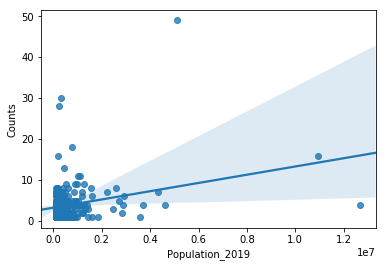

In [11]:
sns.regplot(x="Population_2019", y="Counts", data=df_new);
plt.savefig("figureReg.png")

### Methodology
<b>  The ratio column of the dataframe df_new denotes the ratio of population of the city by per restaurant. So it is the amount of population that a restaurant has to feed. So the larger the number the larger is the workload of the restaurant in that area (assuming that the city contains at least 1 restaurant) - assuming size of all the restaurant is same as well as all restaurants are identical with respect to likeliness, work capacity and size. </b>

<i>Since the city which has the highest ratio has the highest amount of people per restaurant so I would recommend opening a restaurant in that area.</i>

<b>Also lets look at the different restaurants in map and check which cluster our recommended city falls under</b>

In [12]:
Restaurants=India_venues[India_venues['Venue Category'].str.contains('Restau')].reset_index()
Restaurants.drop(['index'], inplace=True, axis=1)
Restaurants.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Delhi,28.65195,77.23149,Karim's | करीम | کریم (Karim's),28.649498,77.233691,Indian Restaurant
1,Delhi,28.65195,77.23149,Al Jawahar | अल जवाहर | امام جواہر,28.649609,77.233555,Indian Restaurant
2,Delhi,28.65195,77.23149,Parawthe Wale,28.656033,77.230500,Indian Restaurant
3,Delhi,28.65195,77.23149,Babu Ram Paranthe Wale,28.655820,77.230448,Indian Restaurant
4,Delhi,28.65195,77.23149,Pt. Gaya Prasad Shiv Charan Paranthewale | पंड...,28.656027,77.230438,Indian Restaurant


In [13]:
address = 'India'

geolocator = Nominatim(user_agent="ind")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

in_map = folium.Map(location=[latitude,longitude], zoom_start=4)

for lat, lng, city, venue, catg in zip(Restaurants['Venue Latitude'], Restaurants['Venue Longitude'], Restaurants['City'], Restaurants['Venue'], Restaurants['Venue Category']):
    label = '{}, {}, {}'.format(venue, catg, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='crimson',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(in_map)  


in_map

In [14]:

India_grouped = Rest_data.groupby('City').mean().reset_index()
India_grouped.head()

Restaurants['Venue Category'].unique()

array(['Indian Restaurant', 'Asian Restaurant', 'Italian Restaurant',
       'French Restaurant', 'Japanese Restaurant',
       'Mediterranean Restaurant', 'Rajasthani Restaurant',
       'Parsi Restaurant', 'Mexican Restaurant', 'Restaurant',
       'Karnataka Restaurant', 'Cantonese Restaurant',
       'Fast Food Restaurant', 'Vegetarian / Vegan Restaurant',
       'Chinese Restaurant', 'Seafood Restaurant',
       'Multicuisine Indian Restaurant', 'Gluten-free Restaurant',
       'Chettinad Restaurant', 'Molecular Gastronomy Restaurant',
       'North Indian Restaurant', 'Cajun / Creole Restaurant',
       'Middle Eastern Restaurant', 'South Indian Restaurant',
       'Hyderabadi Restaurant', 'Afghan Restaurant', 'Turkish Restaurant',
       'Eastern European Restaurant', 'Andhra Restaurant',
       'Northeast Indian Restaurant'], dtype=object)

In [15]:

kclusters = 3
India_grouped_clustering = India_grouped.drop('City', 1)

##run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(India_grouped_clustering)
kmeans.labels_[0:10] 
India_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

Ind_merged = Restaurants
Ind_merged = Ind_merged.join(India_grouped.set_index('City'), on='City')

Ind_merged.head() 


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,Afghan Restaurant,Andhra Restaurant,Asian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Chettinad Restaurant,Chinese Restaurant,Eastern European Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Hyderabadi Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Karnataka Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Multicuisine Indian Restaurant,North Indian Restaurant,Northeast Indian Restaurant,Parsi Restaurant,Rajasthani Restaurant,Restaurant,Seafood Restaurant,South Indian Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,Delhi,28.65195,77.23149,Karim's | करीम | کریم (Karim's),28.649498,77.233691,Indian Restaurant,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Delhi,28.65195,77.23149,Al Jawahar | अल जवाहर | امام جواہر,28.649609,77.233555,Indian Restaurant,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Delhi,28.65195,77.23149,Parawthe Wale,28.656033,77.230500,Indian Restaurant,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Delhi,28.65195,77.23149,Babu Ram Paranthe Wale,28.655820,77.230448,Indian Restaurant,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Delhi,28.65195,77.23149,Pt. Gaya Prasad Shiv Charan Paranthewale | पंड...,28.656027,77.230438,Indian Restaurant,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, city, cluster in zip(Ind_merged['Venue Latitude'], Ind_merged['Venue Longitude'], Ind_merged['City'], Ind_merged['Cluster Labels']):
    label = folium.Popup(str(city) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Also lets check how far from the city centre the restaurant should be?

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


KeyError: 'Counts'

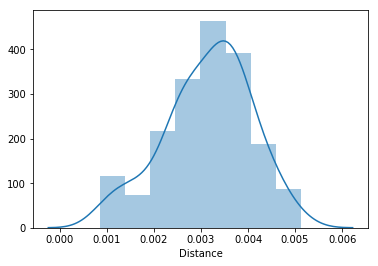

In [21]:
Dumm=Ind_merged[['City','City Latitude','City Longitude','Venue Latitude', 'Venue Longitude']]

Dumm['Distance']=((Dumm['City Latitude']-Dumm['Venue Latitude'])**2+(Dumm['City Longitude']-Dumm['Venue Longitude'])**2)**(1/2)

Distancedf = Dumm.groupby(['City'])['Distance'].mean().reset_index()
Distancedf['Counts']=df_new['Counts']
Distancedf

sns.distplot(Distancedf['Distance'],bins=8)
plt.savefig("figureHist.png")

Dumm['Counts'].sum()

### However the question now is what type of restaurant it must be? 
 To answer this, I have used the top category for the cluster that contains the recommended city name and used it for recommendation

In [18]:
ClusterR=India_grouped[India_grouped['City'] == City_recom]
n=ClusterR['Cluster Labels'].values[0]
Clust=Ind_merged.loc[Ind_merged['Cluster Labels'] == n, Ind_merged.columns[[1] + list(range(1, Ind_merged.shape[1]))]]

In [19]:
Ty=Clust['Venue Category'].mode()

In [20]:
print('The recommendation is for',Ty.values[0],'in',City_recom,'.')

The recommendation is for Fast Food Restaurant in Hyderabad .


# Conlusion

## I have built a recommender system which will recommend a place and type of restaurant to be built in India.